<a href="https://colab.research.google.com/github/vicentcamison/idal_ia3/blob/main/3%20Aprendizaje%20profundo%20(II)/Sesion%201/08_Pytorch_DL_clasificacion_Ejercicio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![IDAL](https://i.imgur.com/tIKXIG1.jpg)  

#<strong>**Máster en Inteligencia Artificial Avanzada y Aplicada  IA^3**</strong>
---


##<center>**Deep learning aplicado a clasificación**<center>

##Ejercicio Propuesto

Empleando como base el Notebook comentado de regresión, realiza ahora la adaptación necesaria para convertirlo a un problema de clasificación. 

En concreto, el objetivo ahora es predecir el tipo de tarifa 0 o 1 que se cobrará por cada viaje, teniendo en cuenta las mismas variables e información que en el caso de regresión. El código es prácicamente igual en muchos aspectos, pero hay que tener en cuenta los cambios necesarios en varios puntos como 
* la variable target pasa a ser otra. Revisa el dataframe para encontrarla
* la arquitectura de la red ahora debe proporcionar dos salidas
* la función de coste a emplear debe ser apropiada para clasificación
* la forma de evaluar los resultados debe cambiar

El Notebook mantiene las mismas secciones y en el mismo orden como guía para el proceso

## Red neuronal completa, problema de clasificación
El objetivo es estimar el **tipo de tarifa** de un viaje en taxi de la ciudad de Nueva York a partir de varios datos. La inspiración detrás de este código es una reciente <a href='https://www.kaggle.com/c/new-york-city-taxi-fare-prediction'>competición de kaggle</a>.

En el notebook nos vamos a centrar en varios aspectos: 

*   Importación de los datos desde ficheros csv
*   Abordaje de un problema real, con diferentes tipos de variables.
*   Procesado de las variables y generación de nuevas
*   Tratamiento de variables categóricas
*   Preparación de un modelo con varias capas ocultas (_deep_)
*   Entrenamiento, validación y testeo del modelo
* Guardado del modelo
* Realización de nuevas predicciones.






## Importaciones standard


In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Carga del dataset NYC Taxi Fares 

La  <a href='https://www.kaggle.com/c/new-york-city-taxi-fare-prediction'>competición de Kaggle</a> provee un conjunto de datos de cerca 55 millones de registros. Los datos solo contienen las fecha, hora, latitud, longitud de la recogida y del destino, el número de pasajeros y el coste del viaje, que es el objetivo a predecir. Queda a elección del participante obtener y emplear cualquier información adicional. Por ejemplo, ¿influye la hora del día? ¿el día de la semana? ¿como determinamos la distancia recorrida?
Para este ejercicio vamos a limitar el dataset a (solo) 120000 registros, desde el 11 al 24 de Abril de 2010. Los registros se han ordenado aleatoriamente. Vamos a ver como podemos calcular distancias desde coordenadas GPS y como preparar un dataframe de pandas con los datos que consideremos necesarios, como aprovechar la información de fecha y hora, generar nuevas variables de interés , etc.


Para cargar los datos del dataset que vamos a emplear tenemos diversas opciones. 
* Los datos originales podemos cargarlos del repositorio de Kaggle de la competición. Sin embargo son muchos datos y en el ejercicio únicamente vamos a emplear una parte de ellos. 
* Podemos cargarlos desde nuestra unidad Drive ejecutando los siguientes scripts y siguiendo las instrucciones. Para montar la unidad nos genera una clave particular que hemos de introducir. A oartir de ese momento, la estructura de carpetas de nuestro disco Drive es accesible para el Notebook dentro de /content/drive. Más detalles en la [doc de Google](https://colab.research.google.com/notebooks/io.ipynb)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# (JUAN) Lo de Google Drive no sé cómo se hace, así que lo que he hecho
# es guardarlo en el github, y cargarlo desde ahí

In [8]:
#Lee el fichero "NYCTaxiFares.csv"  desde tu Drive o localmente y examinalo con head

## TU CÓDIGO AQUÍ
url = 'https://raw.githubusercontent.com/vicentcamison/idal_ia3/main/3%20Aprendizaje%20profundo%20(II)/Sesion%201/NYCTaxiFares.csv'
data = pd.read_csv(url, index_col=0)
data.head()

,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
pickup_datetime,,,,,,,
2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [12]:
data.loc[:,'fare_class'].describe()

count    120000.000000
mean          0.333333
std           0.471406
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: fare_class, dtype: float64

In [13]:
data.loc[:,'fare_class'].value_counts()

0    80000
1    40000
Name: fare_class, dtype: int64

In [ ]:
#Examina la variable target `fare_class`:

## TU CÓDIGO AQUÍ

0    80000
1    40000
Name: fare_class, dtype: int64

Observamos que 2/3 estan por debajo de 10\$ y 1/3 han tenido una tarifa de 10\$ o más.

La correspondencia entre tarifas y la clase asignada es:
<table style="display: inline-block">
<tr><th>Class</th><th>Values</th></tr>
<tr><td>0</td><td>< \$10.00</td></tr>
<tr><td>1</td><td>>= \$10.00</td></tr>
</table>

## Calculando la disancia recorrida

La <a href='https://en.wikipedia.org/wiki/Haversine_formula'>fórmula haversine </a> calcula la distancia en una esfera, dados dos puntos en coordenadas GPS.

Vamos a llamar a la latitud $\varphi$ (phi) y a la longitud $\lambda$ (lambda).

La formula de esta distancia es:

${\displaystyle d=2r\arcsin \left({\sqrt {\sin ^{2}\left({\frac {\varphi _{2}-\varphi _{1}}{2}}\right)+\cos(\varphi _{1})\:\cos(\varphi _{2})\:\sin ^{2}\left({\frac {\lambda _{2}-\lambda _{1}}{2}}\right)}}\right)}$

donde

$\begin{split} r&: \textrm {radio de la esfera (el radio de la Tierra es de promedio 6371 km)}\\
\varphi_1, \varphi_2&: \textrm {latitudes de punto 1 a punto 2}\\
\lambda_1, \lambda_2&: \textrm {longitudes de punto 1 a punto 2}\end{split}$

In [14]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculo de la distancia haversine entre 2 puntos GPS
    """
    r = 6371  # radio de la Tierra en km
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # en km

    return d

Creamos una nueva columna con las distancias calculadas

In [ ]:
## TU CÓDIGO AQUÍ

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


In [18]:
dist_km = pd.DataFrame(data=haversine_distance(data, 'dropoff_latitude', 'dropoff_longitude', 'pickup_latitude', 'pickup_longitude'), columns=['dist_km'])
data.loc[:,'dist_km'] = dist_km
data.reset_index(inplace=True)
data.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


## Columna FechaHora y valores derivados que pueden ser útiles

La Fecha y hora nos vienen en un formato importado de texto. Pasar eso a un objete de fechahora nos permitirá extraer información como el día de la semana, momento del día am o pm, etc.

_**Nota**: Los datos están grabados en formato UTC. Teniendo en cuenta la fecha y el horario que manejan en Nueva York en ese momento, la hora correcta EDT necesita un ajuste de 4 horas menos (UTC-4)_

Generamos las nuevas columnas

In [ ]:
# Genera EDTdate, Hour, AMorPM y Weekday

## TU CÓDIGO AQUÍ

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56,4,am,Mon
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53,11,am,Sat
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26,7,am,Sat
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03,17,pm,Sun
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01,22,pm,Fri


In [ ]:
# Revisa valor mínimo de EDTdate: 

## TU CÓDIGO AQUÍ

Timestamp('2010-04-11 00:00:10')

In [ ]:
# Revisa valor máximo de EDTdate: 

## TU CÓDIGO AQUÍ

Timestamp('2010-04-24 23:59:42')

## Separamos variables categóricas y continuas



Especifica las columnas que vamos a usar de cada tipo. Observemos que **no** vamos a emplear todas. Dejamos fuera pickup_datetime y EDTdate ya que en su lugar vamos a emplear las nuevas columnas categóricas que hemos prparado</div>


In [ ]:
# Muestra los nombres de todas las columnas: 

## TU CÓDIGO AQUÍ

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km', 'EDTdate', 'Hour', 'AMorPM', 'Weekday'],
      dtype='object')

In [ ]:
# Especifica las que corresponden a categóricas, continuas y la variable objetivo

## TU CÓDIGO AQUÍ

## Categorizar

Panda nos permite emplear un tipo de dato <a href='https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html'><strong>category dtype</strong></a> para convertir valores categóricos a códigos numéricos. Así, un dataset con meses del año tendrá asignados 12 códigos, uno por mes (0-11). Lo que hace pandas es sustituir las columnas por códigos y retiene una lista índice de las categorías. En los siguientes pasos llamaremos a las categorías`categories` y a su codificación `codes`

In [ ]:
# Categoriza las variables categóricas

## TU CÓDIGO AQUÍ

In [ ]:
# Comprueba los tipos 

## TU CÓDIGO AQUÍ

pickup_datetime              object
fare_amount                 float64
fare_class                    int64
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dist_km                     float64
EDTdate              datetime64[ns]
Hour                       category
AMorPM                     category
Weekday                    category
dtype: object

Vamos a comprobar como `df['Hour']`es ahora una variable categórica codificada:

In [ ]:
# Comprueba la variable Hour: 

## TU CÓDIGO AQUÍ

0     4
1    11
2     7
3    17
4    22
Name: Hour, dtype: category
Categories (24, int64): [0, 1, 2, 3, ..., 20, 21, 22, 23]

In [ ]:
# Comprueba la variable AMorPM: 

## TU CÓDIGO AQUÍ

0    am
1    am
2    am
3    pm
4    pm
Name: AMorPM, dtype: category
Categories (2, object): ['am', 'pm']

In [ ]:
# Comprueba la variable Weekday: 

## TU CÓDIGO AQUÍ


0    Mon
1    Sat
2    Sat
3    Sun
4    Fri
Name: Weekday, dtype: category
Categories (7, object): ['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed']

**NOTA:** Observese que los días de la semana están codificados sin el orden "normal".

**NOTA2:** Los valores NaN se codifican como -1. No tenemos ninguno en ese conjunto de datos en particular. 

Ahora podemos combinar los códigos de las tres columnas categóricas en un array de entrada con la función de Numpy <a href='https://docs.scipy.org/doc/numpy/reference/generated/numpy.stack.html'><tt>numpy.stack</tt></a>. No necesitamos los índices de las categorías, solo los valores. 

In [ ]:
# Prepara los valores de cada variable y combinalos:

## TU CÓDIGO AQUÍ

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       [17,  1,  3],
       [22,  1,  0]], dtype=int8)

**NOTA:** Esto se puede hacer en una sola línea empleando _list comprehension_:

`cats = np.stack([df[col].cat.codes.values for col in cat_cols], 1)`

De momento no nos preocuparemos por el tipo de datos `dtype`. Lo podremos convertir a int64 cuando pasemos el array a tensor.


## Conversión de numpy arrays a tensores

In [ ]:
# Pasa a tensores las Categoricas

## TU CÓDIGO AQUÍ

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3],
        [22,  1,  0]])

También pasaremos las continuas a tensor para el modelo. No las vamos a normalizar aquí, dejamos ese paso para realizarlo dentro del modelo. 

**NOTA:** Por cuestiones de la normalización que realizaremos posteriormente, vamos a dejar las variables continuas como `Float (float32)` en lugar de `Double (float64)`

In [ ]:
# Pasa a tensores las Continuas 

## TU CÓDIGO AQUÍ

tensor([[ 40.7305, -73.9924,  40.7447, -73.9755,   1.0000,   2.1263],
        [ 40.7406, -73.9901,  40.7441, -73.9742,   1.0000,   1.3923],
        [ 40.7511, -73.9941,  40.7662, -73.9601,   2.0000,   3.3268],
        [ 40.7564, -73.9905,  40.7482, -73.9712,   1.0000,   1.8641],
        [ 40.7342, -73.9910,  40.7431, -73.9060,   1.0000,   7.2313]])

In [ ]:
# verifica el tipo de las continuas

## TU CÓDIGO AQUÍ

'torch.FloatTensor'


**Nota**: La función CrossEntropyLoss que se puede usar para evaluar el coste en un problema de clasificación espera un tensor 1D. Es por ello que se debe reemplazar <tt>.reshape(-1,1)</tt> (genera formato columna) por <tt>.flatten()</tt> (genera formato fila/vector).

In [ ]:
# Convertimos etiquetas a tensor

## TU CÓDIGO AQUÍ

tensor([0, 0, 1, 0, 1])

Comprobamos dimensiones: 

In [ ]:
# de cats
## TU CÓDIGO AQUÍ

torch.Size([120000, 3])

In [ ]:
# de conts
## TU CÓDIGO AQUÍ

torch.Size([120000, 6])

In [ ]:
# del vector de salida y
## TU CÓDIGO AQUÍ

torch.Size([120000])

## Embedding para las variables categóricas

Las variables categóricas proporcionan un mejor resultado si en lugar de tratarlas como un código numérico, realizamos un proceso llamado Embedding (se traduciría como Integración/incrustación). En el embedding cada código asignado se mapea a unas variables nuevas. Esto es así porque el embedding resuelve ciertos problemas que se dan al tratar variables categóricas, que representan categorías a menudo no ordinales, pero sí relacionadas en otros aspectos.

Existen diversas formas de afrontar ese recodificado. Uno de los más simples y conocidos consiste en el OHE _One Hot Encoding_. Sin embargo, existen formas algo más evolucionadas como la que vamos a tratar en este ejercicio. 
El Embedding es una parte fundamental en el procesado de lenguaje natural, aunque su uso no se limita a dicha area. 
Encontramos [aquí](https://medium.com/@davidheffernan_99410/an-introduction-to-using-categorical-embeddings-ee686ed7e7f9) y [aquí](https://towardsdatascience.com/neural-network-embeddings-explained-4d028e6f0526) buenas explicaciones de los que es y porqué es conveniente. 

La regla del pulgar para determinar un tamaño de embedding es dividir el numero total de categorías únicas de la variable en cuestion entre 2, pero sin pasar de 50. 

In [ ]:
# Determina los tamaños para embedding para Hours, AMvsPM y Weekdays

## TU CÓDIGO AQUÍ

[(24, 12), (2, 1), (7, 4)]

## Definimos un modelo tabular (_TabularModel_)

Este tipo de modelo está inspirado en los procedimientos de la librería <a href='https://docs.fast.ai/tabular.models.html'>fast.ai library</a>  El hecho de llamarlo modelo tabular viene de que los datos provienen de tablas, con tipos diferentes y que en mayor o menor medida se han procesado previamente. En ese preprocesado se generan o descartan variables si se considera y se hace una distinción entre variables continuas y categóricas. 
El objetivo final es definir un modelo basado en el número de variables continuas (dado por <tt>conts.shape[1]</tt>) más el número de variables categóricas y sus embeddings (dados por <tt>len(emb_szs)</tt> y <tt>emb_szs</tt> respectivamente).  La salida será una regresión (un valor único, tipo flotante), o una clasificación (un grupo de intervalos y sus valores softmax).



**Vamos a estudiar en detalle los pasos que vamos a realizar a continuación**

1. Extendemos la clase base Module indicandle los siguientes parámetros:
   * <tt>emb_szs: </tt>lista de tuplas: el tamaño de cada variable categórica (número de categorías únicas) junto con el tamaño elegido para su _embedding_
   * <tt>n_cont:  </tt>int: número de variables continuas
   * <tt>out_sz:  </tt>int: tamaño de salida
   * <tt>layers:  </tt>list of ints: tamaño de las capas intermedias que deseemos poner
   * <tt>p:       </tt>float: factor de dropout para cada capa (por simplicidad usaremos el mismo en todas las capas)

<tt><font color=black>class TabularModel(nn.Module):<br>
&nbsp;&nbsp;&nbsp;&nbsp;def \_\_init\_\_(self, emb_szs, n_cont, out_sz, layers, p=0.5):<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;super().\_\_init\_\_()</font></tt><br>

2. Generamos las capas embedded con  <a href='https://pytorch.org/docs/stable/nn.html#modulelist'><tt><strong>torch.nn.ModuleList()</strong></tt></a> y con  <a href='https://pytorch.org/docs/stable/nn.html#embedding'><tt><strong>torch.nn.Embedding()</strong></tt></a>
Los datos categóricos serán filtrados a través del Embeddings en la sección forward de la clase con el siguiente código:<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])</font></tt><br><br>
3. Incluidmos un factor dropout `p` en el embeddings con <a href='https://pytorch.org/docs/stable/nn.html#dropout'><tt><strong>torch.nn.Dropout()</strong></tt></a> Por defecto pondremos `p=0.5`<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.emb_drop = nn.Dropout(emb_drop)</font></tt><br><br>
4. Realizaremos una normalización sobre las variables continuas con <a href='https://pytorch.org/docs/stable/nn.html#batchnorm1d'><tt><strong>torch.nn.BatchNorm1d()</strong></tt></a><br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.bn_cont = nn.BatchNorm1d(n_cont)</font></tt><br><br>
5. Definimos una secuencia de capas de red neuronal donde cada nivel incluirá una función lineal, una función de activación (en nuestro caso <a href='https://pytorch.org/docs/stable/nn.html#relu'><strong>ReLU</strong></a>),
un paso de normalización y un factor de dropout. Para combinar la secuencia de capas usaremos <a href='https://pytorch.org/docs/stable/nn.html#sequential'><tt><strong>torch.nn.Sequential()</strong></tt></a>. Obsérvese que este código permite especificar **tantas capas ocultas** como especifiquemos en el argumento `layers`<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.bn_cont = nn.BatchNorm1d(n_cont)<br>
&nbsp;&nbsp;&nbsp;&nbsp;layerlist = []<br>
&nbsp;&nbsp;&nbsp;&nbsp;n_emb = sum((nf for ni,nf in emb_szs))<br>
&nbsp;&nbsp;&nbsp;&nbsp;n_in = n_emb + n_cont<br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;for i in layers:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.Linear(n_in,i)) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.ReLU(inplace=True))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.BatchNorm1d(i))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.Dropout(p))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;n_in = i<br>
&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.Linear(layers[-1],out_sz))<br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;self.layers = nn.Sequential(*layerlist)</font></tt><br><br>
6. Definimos el método `forward`. En este método se realiza el preprocesado de  embeddings sobre las categóricas y la normalización sobre las continuas antes de unirlas todas y pasarlas a través de las capas. <br>Usaremos <a href='https://pytorch.org/docs/stable/torch.html#torch.cat'><tt><strong>torch.cat()</strong></tt></a> para combinar los tensores en uno.<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;def forward(self, x_cat, x_cont):<br>
&nbsp;&nbsp;&nbsp;&nbsp;embeddings = []<br>
&nbsp;&nbsp;&nbsp;&nbsp;for i,e in enumerate(self.embeds):<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;embeddings.append(e(x_cat[:,i]))<br>
&nbsp;&nbsp;&nbsp;&nbsp;x = torch.cat(embeddings, 1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;x = self.emb_drop(x)<br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;x_cont = self.bn_cont(x_cont)<br>
&nbsp;&nbsp;&nbsp;&nbsp;x = torch.cat([x, x_cont], 1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;x = self.layers(x)<br>
&nbsp;&nbsp;&nbsp;&nbsp;return x</font></tt>
</div>

Teniendo en cuenta todo esto, define la clase `TabularModel`: 

In [ ]:
class TabularModel(nn.Module):

    ## TU CÓDIGO AQUÍ


    

Establece una semilla de 33 para reproducibilidad de resultados e instancia el modelo. 
**NOTA** Configura dos capas ocultas de [200,100] y ten en cuenta que el nuevo modelo requiere 2 salidas. Pon un factor de dropout de 0.4

In [ ]:
## TU CÓDIGO AQUÍ

Comprobemos que la arquitectura es la correcta: 

In [ ]:
## TU CÓDIGO AQUÍ

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=2, bias=True)
  )
)

## Definimos función de coste y optimizador
En ejercicios anteriores hemos usado la función de coste MSE y RMSE. Para nuestro problema de clasificación vamos a usa la fcnión de coste de Entropía Cruzada <a href='https://pytorch.org/docs/stable/nn.html#crossentropyloss'><strong><tt>torch.nn.CrossEntropyLoss()</tt></strong></a><br>

Para el optimizador continuamos <a href='https://pytorch.org/docs/stable/optim.html#torch.optim.Adam'><strong><tt>torch.optim.Adam()</tt></strong></a> 

In [ ]:
# define criterio y optimizador

## TU CÓDIGO AQUÍ

## Preparamos conjuntos de train/test
En este punto, nuestro conjunt es un único lote de 120000 registros.  Esto llevará un tiempo de entrenamiento, por lo que podemos plantearnos reducirlo. Vamos a emplear 60000. Recordemos que los tensores ya estaban ordenados aleatoriamente.

In [ ]:
# Toma un lote de 60000 y reserva el 20% para test
batch_size = 60000
test_size = int(batch_size * .2)

## TU CÓDIGO AQUÍ

In [ ]:
# comprueba cantidad para train
## TU CÓDIGO AQUÍ

48000

In [ ]:
# comprueba cantidad para test
## TU CÓDIGO AQUÍ

12000

## Entrenando el modelo 

Genera un bucle de entrenamiento con todos los pasos que conlleva. Empieza con 300 epochs, aunque esto es a elección. 
Recuerda mostrar cada ciertos epochs información sobre el proceso. Incluye instrucciones e infor para controlar el tiempo empleado en el entrenamiento.


In [ ]:
import time
start_time = time.time()

## TU CÓDIGO AQUÍ

epoch:   1  loss: 0.80580622
epoch:  26  loss: 0.60779369
epoch:  51  loss: 0.57555956
epoch:  76  loss: 0.55590647
epoch: 101  loss: 0.54636055
epoch: 126  loss: 0.53714198
epoch: 151  loss: 0.53024453
epoch: 176  loss: 0.52593130
epoch: 201  loss: 0.51980352
epoch: 226  loss: 0.51454335
epoch: 251  loss: 0.51070338
epoch: 276  loss: 0.50730860
epoch: 300  loss: 0.50315452

Duration: 400 seconds


## Visualizamos la función de error 

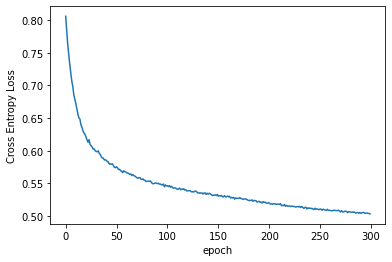

In [ ]:
# Plotea la pérdida/error frente a los epochs

## TU CÓDIGO AQUÍ

## Validamos el modelo
Ahora vamos a lanzar el modelo con el conjunto de test y a comparar los resultados con las etiquetas conocidas. 

Dado que en este paso no es necesario actualizar pesos ni biases, no es necesario emplear la función autograd, por lo que ponemos <tt>torch.no_grad()</tt> y evitamos cálculos (y tiempo ) innecesario.

In [ ]:
# (método validation_step en el ejemplo anterior)

## TU CÓDIGO AQUÍ

CE Loss: 0.24657105


El valor del CE por sí solo no es un buen indicador en este caso. 

Vamos a obtener la precision del modelo calculando la tasa de aciertos para todos los registros del conjunto de test, imprimiendo únicamente el resultado final

In [ ]:
# Recorremos todos los elementos de y_test y comprobamos con y_val

## TU CÓDIGO AQUÍ


10895 out of 12000 = 90.79% correct


## Guardando el modelo entrenado
Recordemos que podemos salvar un modelo entrenado como un fichero en disco de forma que podamos recuperarlo posterormente para realizar predicciones o continuar entrenandolo con más datos. 
Habitualmente lo que suele hacerse es salvar las matrices de pesos y biases y no toda la definición. Podemos encontrar más información sobre el proceso de guardado y sus recomendaciones en  <a href='https://pytorch.org/tutorials/beginner/saving_loading_models.html'>https://pytorch.org/tutorials/beginner/saving_loading_models.html</a>

In [ ]:
# Aseguramos que lo guardao SOLO depués de haberlo entrenado!

## TU CÓDIGO AQUÍ


Ahora podemos definir una función que solicite los datos de entrada al usuario , realice todos los pasos de preprocesado definidos al principio del Notebook y los pase al modelo entrenado con el fin de obtener una predicción concreta. 

## Introduciendo nuevos datos a través del modelo

Define una función para introducir los datos y que muestre la nueva predicción con ellos:

In [ ]:
def test_data(mdl): # nombre del modelo que hemos instanciado
    # Nuevos datos:
   
   ## TU CÓDIGO AQUÍ
    
    # Preprocesado de lso datos:
    ## TU CÓDIGO AQUÍ
   
    
    # Recodificamos las categoricas:
    ## TU CÓDIGO AQUÍ

    # Creamos y concatenamos tensores
    ## TU CÓDIGO AQUÍ
    
    # Pasamos los nuevos datos al modelo. Sin backpropagacion
    
    ## TU CÓDIGO AQUÍ
    print(f'\nLa tarifa resultante es {z}')
    


Como referencia, estos son los valores máximos y mínimos de las variables solicitadas:
<table style="display: inline-block">
<tr><th>Column</th><th>Mínimo</th><th>Máximo</th></tr>
<tr><td>pickup_latitude</td><td>40</td><td>41</td></tr>
<tr><td>pickup_longitude</td><td>-74.5</td><td>-73.3</td></tr>
<tr><td>dropoff_latitude</td><td>40</td><td>41</td></tr>
<tr><td>dropoff_longitude</td><td>-74.5</td><td>-73.3</td></tr>
<tr><td>passenger_count</td><td>1</td><td>5</td></tr>
<tr><td>EDTdate</td><td>2010-04-11 00:00:00</td><td>2010-04-24 23:59:42</td></tr>

<strong>ATENCION!</strong> La distancia entre 1 grado de latitud (40 a 41) is 111km y en q grade de longitud (-73 a -74) is 85km. El viaje más largo en el dataset muestra una diferencia de solo 0.243 grados lat. y  0.284 de long. La iferencia media para ambos está en torno a 0.02. Para obtener una buena predicción hay que emplear valores cercanos. 

Probamos la función instanciando el modelo en un nuevo objeto y cargando los pesos que hemos guardado

In [ ]:
# Definimos antes los tamaños del embedding y luego instanciamos:
emb_szs = [(24, 12), (2, 1), (7, 4)]
model2 = TabularModel(emb_szs, 6, 2, [200,100], p=0.4)

In [ ]:
# Cargamos los valores guardado en el nuevo objeto: 
model2.load_state_dict(torch.load('/content/TaxiFareClssModel.pt'));
model2.eval() # No olvidar este paso

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=2, bias=True)
  )
)

In [ ]:
z = test_data(model2)

Latitud de recogida: 40.7
Longitud de recogida: -74.33
Latitud de entrega:  40.8
Longitud de entrega: -74.4
Número de pasajeros 3
Especifica la fecha y hora en formato YYYY-MM-DD HH:MM:SS     2010-04-20 00:30:00

The predicted fare class is 1



Enhorabuena si has completado todas las secciones!

## Fin del Notebook